# Introduction to Machine Learning, UZH 2018, Group Project
### Group 2: Barbara Capl, Mathias Lüthi, Pamela Matias, Stefanie Rentsch
##       
# 2. Feature Selection (Extraction)
# A. with Principal Component Analysis (PCA)

###        
In this section we use the feature matrices and the response vector that we prepared in chapter 1.  


####  We will do Feature Selection (Extraction) and generate feature matrices with only selected n features for each Version above
###   
   


In [1]:
# hide unnecessary warnings ("depreciation" of packages etc.)
import warnings
warnings.filterwarnings('ignore')

# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA

## 2.0. SETTINGS: choose which Feature Matrix (Version 1 or 2) you want to use

#### Choose the Dataset Version you want
VERSION = 1; Feature Matrix with only ratios                                  
VERSION = 2;  Feature Matrix with ratios + saisonality + other market data


In [2]:
### Chose which dataset version you want the selection of features and the prediction to be based on 
VERSION = 1
"""
INSERT NUMBER 1 or 2
"""


# Defining sel_state variable for usage later and printing text according to your choise     
if VERSION == 1:
    sel_version = 'based on Dataset with only the Ratios Dataset as predicive Features.'
    print('You chose Version 1 as working dataset. The following Feature Selection will be therefore ' + sel_version)
elif VERSION == 2:
    sel_version = 'based on Dataset with Ratios + Seasonality + other Market Data as predictive Features.'
    print('You chose Version 2 as working dataset. The following Feature Selection will be therefore ' + sel_version)
else: raise ValueError('VERSION must be either 1 or 2')

You chose Version 1 as working dataset. The following Feature Selection will be therefore based on Dataset with only the Ratios Dataset as predicive Features.


## 2.1. Preparation


### 2.1.1 Import the Response Vector and the Feature Matrices

In [3]:
# Load in the response vector pre-generated in Chater 1 (Preparation of Data)
y = pd.read_csv('Data/generated_datasets/response_1.csv', sep=',', header=0)

In [4]:
# Load in te feature matrix according to the version you chose in section 2.0. above
if VERSION == 1:
    X = pd.read_csv('Data/generated_datasets/features_ratios_1.csv', sep=',', header=0)
elif VERSION == 2:
    X = pd.read_csv('Data/generated_datasets/features_additional_1.csv', sep=',', header=0)
else: raise ValueError('VERSION value must be either 1 or 2')

### 2.1.2. Train/ Test Split, fill missing values with median and standardize

Note: For PCA, Standardization is needed before applying PCA algorithm.

### Train/ Test Split

In [5]:
# Train/test split, into 20% test size and 80% train size because it is a relatively small dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Extract all the feature labels for the respective chosen version
feature_labels = list(X)
print('Type of feature_labels = ' + str(type(feature_labels)),'\n')
#display(np.array(feature_labels))

Type of feature_labels = <class 'list'> 



### Filling missing values (NaN)
We use Imputer to fill missing entries with median only AFTER the split, to circumvent the bias that both splits would include information of each other.

In [6]:
# Use a median fill for train
imp = Imputer(missing_values=np.nan, strategy = 'median' , axis=0)
imputed_dataset = pd.DataFrame(imp.fit_transform(X_train))
imputed_dataset.columns = X_train.columns
imputed_dataset.index = X_train.index
X_train = imputed_dataset

# Use a median fill for the test set
imputed_dataset = pd.DataFrame(imp.fit_transform(X_test))
imputed_dataset.columns = X_test.columns
imputed_dataset.index = X_test.index
X_test = imputed_dataset

### Standardization

In [7]:
# Standardization with sklearn StandardScaler
standard_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

  
## 2.2. Run PCA on whole Training Set for all possible PCAs (= number of columns)

### 2.2.1.  Generate PCA object and show plots

In [8]:
# Run PCA for all possible PCAs
pca_a = PCA().fit(X_train)

# Define maximal number of principal components => the "1" in shape[1] refers to columns ("0" would be rows)
q_a = X_train.shape[1]

# Get the amount of variance that each PC explains
# The eigenvalues represent the variance in the direction of the eigenvector
# These numbers for each component are proportional to the Eigenvalues 
# This means that the ratio of the eigenvalue of the first principal component 
# to the eigenvalue of the second principal component is 0.16214649
# SEE => https://stackoverflow.com/questions/37757172/finding-and-utilizing-eigenvalues-and-eigenvectors-from-pca-in-scikit-learn?rpca.q=1
expl_var_a = pca_a.explained_variance_ratio_

# Get cumulative sum of the PCA 1-q_a
sum_expl_var_a = np.cumsum(expl_var_a)[:q_a]

# because we run PCA for all possible PCAs, sum of al Explained Variance in Total of the training set should be 1
print('Explained Variance, first 10 rows: ')
print(expl_var_a[0:10],'\n')
print('Explained Variance in Total = ' + str(expl_var_a.sum())+'\n')
print('Cumulative explained Variance, first 10 rows: ')
print(sum_expl_var_a[0:10], '\n')
print('Maximal number (q_a) of PCs is: ' + str(q_a), '\n')

Explained Variance, first 10 rows: 
[0.20578405 0.13680895 0.0757929  0.05987882 0.04687191 0.04132596
 0.03515177 0.03286437 0.03234243 0.02745725] 

Explained Variance in Total = 0.9999999999999999

Cumulative explained Variance, first 10 rows: 
[0.20578405 0.342593   0.4183859  0.47826473 0.52513663 0.5664626
 0.60161437 0.63447874 0.66682117 0.69427841] 

Maximal number (q_a) of PCs is: 71 



### 2.2.2.  Plot cumulative explained variace

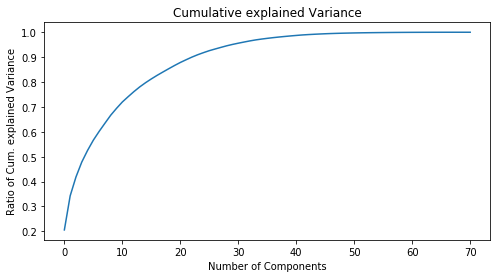

In [9]:
# Plot curve with cumulative sum
plt.figure(figsize = (8, 4))
plt.plot(sum_expl_var_a)
plt.title('Cumulative explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Cum. explained Variance')
plt.xticks(range(0, q_a + 1, 10))
plt.show();

### 2.1.2  Plot explained variance by single components

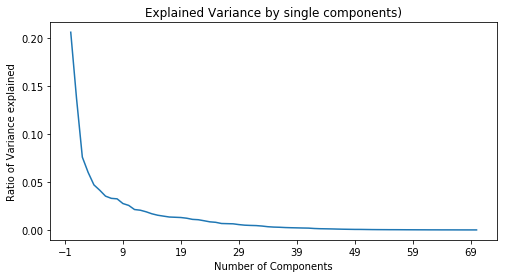

In [10]:
# Plot curve with explained variance
plt.figure(figsize = (8, 4))
plt.plot(expl_var_a)
plt.title('Explained Variance by single components)')
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Variance explained')
plt.xticks(range(-1, q_a + 1, 10))
plt.show();

### 2.1.3 Plot feature importances

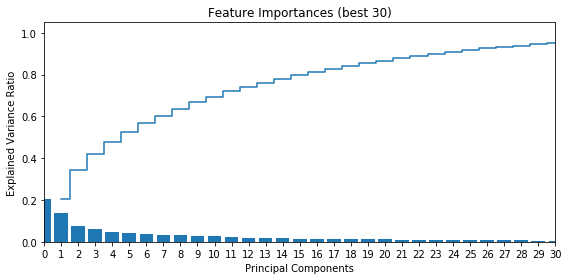

In [11]:
# Plot Feature Importances (both cumulative and idividual)
plt.figure(figsize = (8, 4))
plt.title('Feature Importances (best 30)')
plt.bar(range(0, q_a), expl_var_a, align = 'center')
plt.xticks(range(0, q_a + 1, 1))
plt.xlim([0, 30])
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.step(range(1, q_a + 1), sum_expl_var_a, where = 'mid')
plt.tight_layout();

## 2.3.  Run PCA on whole Training Set for selected number 'q' of PCAs

### 2.2.1. Choose number of Principal Components  and get them for further use

In [12]:
# Define number of principal components we wish to extract
q = 10

# Create PCA object
pca = PCA(n_components = q)

# Fit PCA object to find first principal components
pca.fit(X_train)

print('PCA Object; ' + str(pca), '\n')

# Get the amount of variance that each PC explains
# The eigenvalues represent the variance in the direction of the eigenvector
# These numbers for each component are proportional to the Eigenvalues 
# This means that the ratio of the eigenvalue of the first principal component 
# to the eigenvalue of the second principal component is 0.16214649
# SEE => https://stackoverflow.com/questions/37757172/finding-and-utilizing-eigenvalues-and-eigenvectors-from-pca-in-scikit-learn?rpca.q=1
expl_var = pca.explained_variance_ratio_

# Get cumulative sum of the PCA 1-q_1
sum_expl_var = np.cumsum(expl_var)[:q]

# because we run PCA for only q_1 components, sum of al explained Variance of the training set should be LESS than 1

print('Explained Variance, first 10 rows: ')
print(expl_var[0:10], '\n')
print('Explained Variance in Total = ' + str(expl_var.sum()), '\n')
print('Cumulative explained Variance, first 10 rows: ')
print(sum_expl_var[0:10], '\n')

PCA Object; PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False) 

Explained Variance, first 10 rows: 
[0.20578405 0.13680895 0.0757929  0.05987879 0.04687183 0.04132587
 0.03514931 0.03286085 0.03234202 0.02745107] 

Explained Variance in Total = 0.6942656468719344 

Cumulative explained Variance, first 10 rows: 
[0.20578405 0.342593   0.4183859  0.47826469 0.52513652 0.56646239
 0.6016117  0.63447255 0.66681457 0.69426565] 



### 2.2.2.  Extract q_1 /q_2 number of features out of Training Set; Transform feature matrix with pca object

In [13]:
# Extract q number of features according to pca analysis
# WEBSITE => https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/
X_train_transformed = pca.fit_transform(X_train)

# display properties
print('Shape of PCA-transformed X_train set (should have only q columns) = '+ str(X_train_transformed.shape),'\n')
print('Shape of untransformed X_train set (should have more than q columns) = '+ str(X_train.shape))


# This gives the Eigenvalues?

Shape of PCA-transformed X_train set (should have only q columns) = (2836, 10) 

Shape of untransformed X_train set (should have more than q columns) = (2836, 71)


### 2.2.3. Transform new data (Test set) using the already fitted pca object and save the resulting feature matrices

### Transform the Test Feature Matrix and create pandas dataframe

In [14]:
# Goal: Test Set has the same features as training set
X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)

# Put the X Sets into a pandas dataframe (they are numpy)
X_train_p = pd.DataFrame(X_train_transformed)
X_test_p = pd.DataFrame(X_test_transformed)  

# display properties
print('Shape of PCA-transformed X_test set (should have only q columns) = '+ str(X_test_transformed.shape),'\n')
print('Shape of untransformed X_test set (should have more than q columns) = '+ str(X_test.shape))

Shape of PCA-transformed X_test set (should have only q columns) = (710, 10) 

Shape of untransformed X_test set (should have more than q columns) = (710, 71)


### Save PCA- transformed Fature Matrices and the Respose Vector

In [15]:
if VERSION == 1:
    X_train_p.to_csv('Data/generated_splits/features_selected_pca/X1_train_p.csv', index = False)
    X_test_p.to_csv('Data/generated_splits/features_selected_pca/X1_test_p.csv', index = False)
    y_train.to_csv('Data/generated_splits/features_selected_pca/y1_train_p.csv', index = False)
    y_test.to_csv('Data/generated_splits/features_selected_pca/y1_test_p.csv', index = False)
elif VERSION == 2:
    X_train_p.to_csv('Data/generated_splits/features_selected_pca/X2_train_p.csv', index = False)
    X_test_p.to_csv('Data/generated_splits/features_selected_pca/X2_test_p.csv', index = False)
    y_train.to_csv('Data/generated_splits/features_selected_pca/y2_train_p.csv', index = False)
    y_test.to_csv('Data/generated_splits/features_selected_pca/y2_test_p.csv', index = False)
else: raise ValueError('VERSION value must be either 1 or 2')